In [42]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import sklearn.model_selection as sklrn
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11828775933091414066
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9857662976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6364520140792617738
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [43]:
train_dir = '..\Dataset-fix'

train_X = []
train_labels = []

for label in os.listdir(train_dir):
    PATH_TRAIN_LABEL = os.path.join(train_dir, label)
    for img in os.listdir(PATH_TRAIN_LABEL):
        train_X.append(
            os.path.join(PATH_TRAIN_LABEL, img)
        )
        train_labels.append(label)

train_X = np.array(train_X)
train_labels = np.array(train_labels)

print ('Training shape:', train_X.shape, train_labels.shape) 
print(train_X[:5], train_labels[:-5])

Training shape: (1927,) (1927,)
['..\\Dataset-fix\\busuk\\captured_image_2024-01-07_18-31-27.jpg'
 '..\\Dataset-fix\\busuk\\captured_image_2024-01-07_18-32-01.jpg'
 '..\\Dataset-fix\\busuk\\captured_image_2024-01-07_18-32-23.jpg'
 '..\\Dataset-fix\\busuk\\captured_image_2024-01-07_18-32-26.jpg'
 '..\\Dataset-fix\\busuk\\captured_image_2024-01-07_18-32-28.jpg'] ['busuk' 'busuk' 'busuk' ... 'setengah matang' 'setengah matang'
 'setengah matang']


In [44]:
model = tf.keras.models.Sequential([
    #konvolusi pertama
    # Depth 16, kernel size 3x3 matrix
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #konvolusi kedua
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #konvolusi ketiga
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #flatten dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    #fully connected layers
    tf.keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(4, activation='softmax')    #ubah dense dari 6 menjadi 4 (tf.keras.layers.Dense(4, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
TRAIN_TEST_SPLIT_AT = 0.9
BATCH_SIZE = 100
TARGET_SIZE = (128, 128)
NO_OF_EPOCHS = 100
EXPERIMENT_SIZE = 10000
NO_OF_FOLDS = 10

In [46]:
def train_and_cross_validate (model, x_data, y_data, n_folds=NO_OF_FOLDS, epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE):
    # 
    scores = []
    
    #  Loading images through generators ...
    train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)    
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
          
    # prepare cross validation
    kfold = sklrn.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 0 
    for train_ix, test_ix in kfold.split(x_data):
        print ('Folds Set # {0}'.format(FoldsSetNo))
        # select rows for train and test
        xx_train, yy_train, xx_test, yy_test = \
            x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]

        # flow training images in batches for the current folds set
        # for training         
        train_generator = train_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_train,'label':yy_train}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='categorical',
            shuffle = False)
        
        # and for validation         
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_test,'label':yy_test}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='categorical',
            shuffle=False)

        # fit the model
        history = model.fit(train_generator,
                            epochs=epochs,  # The more we train the more our model fits the data
                            batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                            validation_data=validation_generator,
                            verbose=1)
        # store scores
        scores.append({'acc':np.average(history.history['accuracy']),'val_acc':np.average(history.history['val_accuracy'])})
        FoldsSetNo +=1

    return scores
print('Starting training and k-fold cross validation ...')
scores = train_and_cross_validate(model, train_X, train_labels)

Starting training and k-fold cross validation ...
Folds Set # 0
Found 1734 validated image filenames belonging to 4 classes.
Found 193 validated image filenames belonging to 4 classes.
Epoch 1/100
18/18 [==============================] - 7s 352ms/step - loss: 1.9700 - accuracy: 0.1459 - val_loss: 1.3465 - val_accuracy: 0.3057
Epoch 2/100
18/18 [==============================] - 6s 328ms/step - loss: 1.3822 - accuracy: 0.2976 - val_loss: 1.3322 - val_accuracy: 0.4249
Epoch 3/100
18/18 [==============================] - 6s 319ms/step - loss: 1.3394 - accuracy: 0.2768 - val_loss: 1.2491 - val_accuracy: 0.4041
Epoch 4/100
18/18 [==============================] - 6s 317ms/step - loss: 1.2818 - accuracy: 0.3529 - val_loss: 1.1008 - val_accuracy: 0.5337
Epoch 5/100
18/18 [==============================] - 6s 318ms/step - loss: 1.2128 - accuracy: 0.3345 - val_loss: 0.7953 - val_accuracy: 0.5596
Epoch 6/100
18/18 [==============================] - 6s 322ms/step - loss: 1.0575 - accuracy: 0.4579

[0.8959688605368137, 0.9769088876247406, 0.9922087728977204, 0.9997981584072113, 0.9776066899299621, 0.9994925093650818, 0.9754440629482269, 0.9937867373228073, 0.9995965367555618, 0.9933832824230194]
[0.9369430047273636, 0.9835232990980148, 0.9960103625059128, 1.0, 0.9881347066164017, 1.0, 0.9869948181509972, 0.9977604174613952, 1.0, 0.9967708337306976]


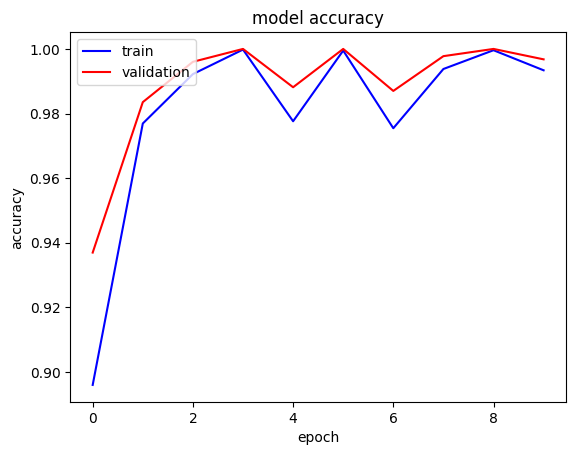

In [47]:
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Found 1927 images belonging to 4 classes.
61/61 [==============================] - 13s 222ms/step


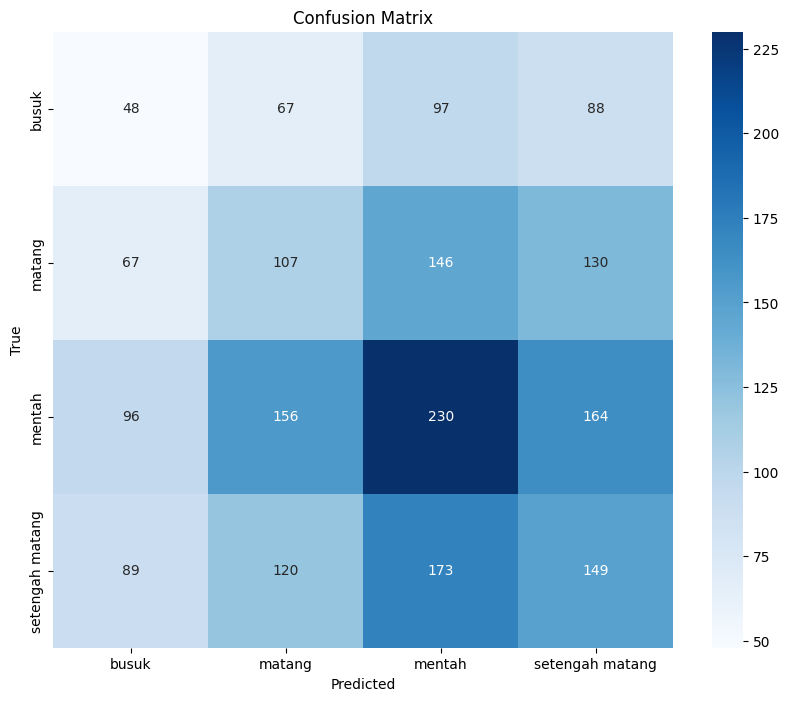

In [54]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '../Dataset-fix/',
    target_size=(128, 128),
    class_mode='categorical'
)

predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [55]:
predictions = model.predict(
    
    , steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(class_report)

61/61 [==============================] - 3s 50ms/step
Confusion Matrix:
[[ 46  77  99  78]
 [ 77 106 159 108]
 [ 87 161 210 188]
 [ 90 106 178 157]]
Classification Report:
                 precision    recall  f1-score   support

          busuk       0.15      0.15      0.15       300
         matang       0.24      0.24      0.24       450
         mentah       0.33      0.33      0.33       646
setengah matang       0.30      0.30      0.30       531

       accuracy                           0.27      1927
      macro avg       0.25      0.25      0.25      1927
   weighted avg       0.27      0.27      0.27      1927

